HYBRID APPROACH 

In [32]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Movie dataset from Kaggle 

In [35]:
raw_data = pd.read_csv("/content/drive/MyDrive/DATASETS/New processed Data For Hybrid/movie_dataset.csv")
raw_data.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [36]:
raw_data.describe()

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.000000,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2401.000000,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,1386.651002,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1200.500000,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,2401.000000,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,3601.500000,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,4802.000000,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [37]:
raw_data.shape

(4803, 24)

In [38]:
raw_data.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

In [39]:
raw_data[raw_data.duplicated()]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director


In [40]:
df = raw_data[['genres','original_title','release_date','vote_average','vote_count','cast', 'director']]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   genres          4775 non-null   object 
 1   original_title  4803 non-null   object 
 2   release_date    4802 non-null   object 
 3   vote_average    4803 non-null   float64
 4   vote_count      4803 non-null   int64  
 5   cast            4760 non-null   object 
 6   director        4773 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 262.8+ KB


In [42]:
df.head(2)

,genres,original_title,release_date,vote_average,vote_count,cast,director
0,Action Adventure Fantasy Science Fiction,Avatar,2009-12-10,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron
1,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,2007-05-19,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski


In [43]:
# string date to Df fromate
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] =pd.DatetimeIndex(df['release_date']).year
df = df.drop('release_date',axis=1)

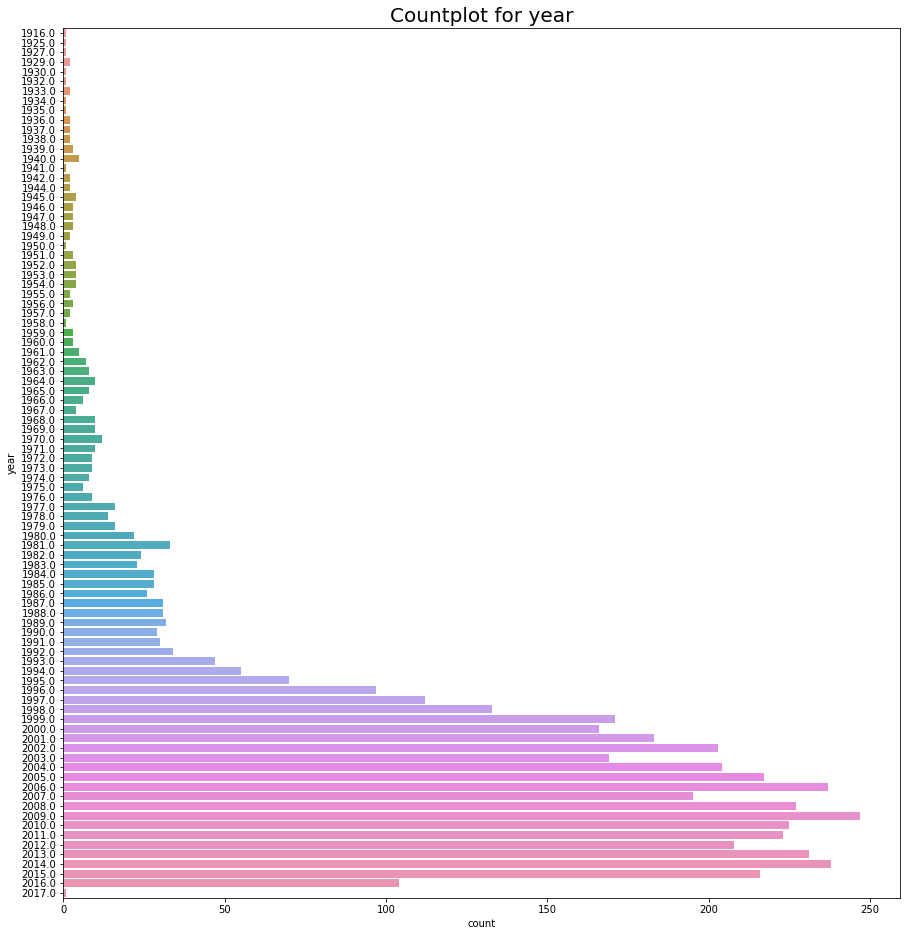

In [44]:
# 2017 Tak data hai 
# 2009 Mai sabse jyada data
plt.figure(figsize=[15,16])
sns.countplot(data=df, y='year')
plt.title('Countplot for year', fontsize = 20)
plt.show()

In [45]:
df = df.drop("year", axis=1)

In [46]:
df.isna().sum()

genres            28
original_title     0
vote_average       0
vote_count         0
cast              43
director          30
dtype: int64

In [47]:
# Filing nan value with blank string
df['genres'] = df['genres'].replace(np.nan," ")
df['cast'] = df['cast'].replace(np.nan," ")
df['director'] = df['director'].replace(np.nan," ")
df["director"] = df['cast'].replace(np.nan," ")

Phir se Scrap karna hoga :-|

In [48]:
# Scraping 2018, 2019, 2020 mov data from wiki
link1 = "https://en.wikipedia.org/wiki/List_of_American_films_of_2018"
link2 = "https://en.wikipedia.org/wiki/List_of_American_films_of_2019"
link3 = "https://en.wikipedia.org/wiki/List_of_American_films_of_2020"

df1 = pd.read_html(link1,header=0)[2]
df2 = pd.read_html(link1,header=0)[3]
df3 = pd.read_html(link1,header=0)[4]
df4 = pd.read_html(link1,header=0)[5]

df5 = pd.read_html(link2, header=0)[3]
df6 = pd.read_html(link2, header=0)[4]
df7 = pd.read_html(link2, header=0)[5]
df8 = pd.read_html(link2, header=0)[6]

#######################################
df9 = pd.read_html(link3, header=0)[3]
df10 = pd.read_html(link3, header=0)[4]
df11 = pd.read_html(link3, header=0)[5]
df12 = pd.read_html(link3, header=0)[6]

# combine all scraped dataframe in one
frame = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]
wiki_df = pd.concat(frame).reset_index(drop=True)

In [49]:
wiki_df.head(3)

,Opening,Opening.1,Title,Production company,Cast and crew,Ref.,Unnamed: 0,"Wikimedia Commons has media related to Films of the United States, 2019."
0,JANUARY,5.0,Insidious: The Last Key,Universal Pictures / Blumhouse Productions / S...,Adam Robitel (director); Leigh Whannell (scree...,[2],NaN,NaN
1,JANUARY,5.0,The Strange Ones,Vertical Entertainment,Lauren Wolkstein (director); Christopher Radcl...,[3],NaN,NaN
2,JANUARY,5.0,Stratton,Momentum Pictures,"Simon West (director); Duncan Falconer, Warren...",[4],NaN,NaN


In [50]:
#TMDB KI API - FOR Data like vote count genre vote avg for better simi. matrics
!pip install tmdbv3api

In [51]:
from tmdbv3api import TMDb,Movie
import json
import requests

#TMDB obj
tmdb = TMDb()
tmdb.api_key = '62fd9021dbeec142016bbfc8e3888baf'
tmdb_movie = Movie()
# This Function take movie title and return movie genre, vote_average, vote_count
def get_genre(title):
    try:
        result = tmdb_movie.search(title)
        movie_id = result[0].id
        response = requests.get('https://api.themoviedb.org/3/movie/{}?api_key={}'.format(movie_id,tmdb.api_key))
        data_json = response.json()
        # Fetching
        movie_ids = []
        mids_str = " "
        for i in range(0,len(data_json['genres'])):
            movie_genres.append(data_json['genres'][i]['name'])
        genre = genr_str.join(movie_genres)
        
        # Fetching vote average and vote count
        vote_average = data_json['vote_average']
        vote_count = data_json['vote_count']
    except:
        vote_average = np.nan
        vote_count = np.nan
        genre = np.nan
    return genre,vote_average,vote_count

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# columns...................
wiki_df['Genre'] = wiki_df['Title'].apply(lambda x:get_genre(x)[0])
wiki_df['Vote_Average'] = wiki_df['Title'].apply(lambda x:get_genre(x)[1])
wiki_df['Vote_Count'] = wiki_df['Title'].apply(lambda x:get_genre(x)[2])

In [53]:
wiki_df2= wiki_df[["Title","Cast and crew","Genre","Vote_Average","Vote_Count"]]
wiki_df2.head()

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,Insidious: The Last Key,Adam Robitel (director); Leigh Whannell (scree...,NaN,NaN,NaN
1,The Strange Ones,Lauren Wolkstein (director); Christopher Radcl...,NaN,NaN,NaN
2,Stratton,"Simon West (director); Duncan Falconer, Warren...",NaN,NaN,NaN
3,Sweet Country,"Warwick Thornton (director); David Tranter, St...",NaN,NaN,NaN
4,The Commuter,Jaume Collet-Serra (director); Byron Willinger...,NaN,NaN,NaN


In [54]:
wiki_df2[wiki_df2.isna().any(axis=1)]

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,Insidious: The Last Key,Adam Robitel (director); Leigh Whannell (scree...,NaN,NaN,NaN
1,The Strange Ones,Lauren Wolkstein (director); Christopher Radcl...,NaN,NaN,NaN
2,Stratton,"Simon West (director); Duncan Falconer, Warren...",NaN,NaN,NaN
3,Sweet Country,"Warwick Thornton (director); David Tranter, St...",NaN,NaN,NaN
4,The Commuter,Jaume Collet-Serra (director); Byron Willinger...,NaN,NaN,NaN
...,...,...,...,...,...
730,We Can Be Heroes,Robert Rodriguez (director/screenplay); Priyan...,NaN,NaN,NaN
731,News of the World,Paul Greengrass (director/screenplay); Luke Da...,NaN,NaN,NaN
732,One Night in Miami,Regina King (director); Kemp Powers (screenpla...,NaN,NaN,NaN
733,Promising Young Woman,Emerald Fennell (director/screenplay); Carey M...,NaN,NaN,NaN


In [55]:
wiki_df2 =  wiki_df2.fillna({'Genre':'', 'Vote_Average':0,'Vote_Count':0})

In [58]:
# Cheking random row values of cast and crew column.
sent_1 = wiki_df2['Cast and crew'][1]
sent_2 = wiki_df2['Cast and crew'][55]
sent_3 = wiki_df2['Cast and crew'][42]
sent_4 = wiki_df2['Cast and crew'][88]
sent_5 = wiki_df2['Cast and crew'][500]
print(sent_1)
print("====================================")
print(sent_2)
print("====================================")
print(sent_3)
print("====================================")
print(sent_4)
print("====================================")
print(sent_5)

Lauren Wolkstein (director); Christopher Radcliff (co-director/screenplay); Alex Pettyfer, James Freedson-Jackson, Emily Althaus, Gene Jones, Owen Campbell, Tobias Campbell
Jon Erwin (director/screenplay); Andrew Erwin (co-director), Alex Cramer, Brent McCorkle (screenplay); Cloris Leachman, Dennis Quaid, Priscilla Shirer, Madeline Carroll, J. Michael Finley, Trace Adkins
Eli Roth (director); Joe Carnahan (screenplay); Bruce Willis, Vincent D'Onofrio, Dean Norris, Kimberly Elise, Mike Epps, Elisabeth Shue, Camila Morrone
Peter Livolsi (director/screenplay); Asa Butterfield, Nick Offerman, Ellen Burstyn, Alex Wolff, Maude Apatow
Benh Zeitlin (director/screenplay); Eliza Zeitlin (screenplay); Tommie Lynn Milazzo, Shay Walker


In [59]:
# Preprocessing.
preprocessed = []
for sentance in wiki_df2['Cast and crew'].values:
    
    # convert all uppercase-lowercase
    sentance = sentance.lower()
    sentance = re.sub(r"director","", sentance)
    sentance = re.sub(r"co-director/screenplay","", sentance)
    sentance = re.sub(r"co-/screenplay","", sentance)
    sentance = re.sub(r"screenplay","", sentance)
    sentance = re.sub(r"director/screenplay","", sentance)
    
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) 
    sentance = re.sub(' +', ' ', sentance) 
    # tokenizing the review by words
    sentance = sentance.split() 
    sentance = ' '.join(sentance)
    # creating a corpus
    preprocessed.append(sentance)
    
wiki_df2["Cast and crew"] = preprocessed


In [60]:
 #Now again check random row values of cast and crew column after cleaning.
sent_1 = wiki_df2['Cast and crew'][1]
sent_2 = wiki_df2['Cast and crew'][55]
sent_3 = wiki_df2['Cast and crew'][42]
sent_4 = wiki_df2['Cast and crew'][88]
sent_5 = wiki_df2['Cast and crew'][500]
sent_6 = wiki_df2['Cast and crew'][707]
print(sent_1)
print("====================================")
print(sent_2)
print("====================================")
print(sent_3)
print("====================================")
print(sent_4)
print("====================================")
print(sent_5)
print("====================================")
print(sent_6)
print("====================================")

lauren wolkstein christopher radcliff alex pettyfer james freedson jackson emily althaus gene jones owen campbell tobias campbell
jon erwin andrew erwin co alex cramer brent mccorkle cloris leachman dennis quaid priscilla shirer madeline carroll j michael finley trace adkins
eli roth joe carnahan bruce willis vincent d onofrio dean norris kimberly elise mike epps elisabeth shue camila morrone
peter livolsi asa butterfield nick offerman ellen burstyn alex wolff maude apatow
benh zeitlin eliza zeitlin tommie lynn milazzo shay walker
sharon maguire kari granlund melissa stack isla fisher jillian bell santiago cabrera


In [61]:
wiki_df2.head()

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,Insidious: The Last Key,adam robitel leigh whannell lin shaye angus sa...,,0.0,0.0
1,The Strange Ones,lauren wolkstein christopher radcliff alex pet...,,0.0,0.0
2,Stratton,simon west duncan falconer warren davis ii dom...,,0.0,0.0
3,Sweet Country,warwick thornton david tranter steven mcgregor...,,0.0,0.0
4,The Commuter,jaume collet serra byron willinger philip de b...,,0.0,0.0


In [62]:
# Text Preprocessing on movie genre column
preprocessed = []
for sentance in wiki_df2['Genre'].values:
    
    # convert all uppercase string into lowercase
    sentance = sentance.lower()
    
    # removing special symbol
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) 
    
    # removing extra space
    sentance = re.sub(' +', ' ', sentance) 
    
    # tokenizing the review by words
    sentance = sentance.split() 
    sentance = ' '.join(sentance)
    
    # creating a corpus
    preprocessed.append(sentance) # Creating a corpus
    
wiki_df2["Genre"] = preprocessed

In [63]:
wiki_df2.head()

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,Insidious: The Last Key,adam robitel leigh whannell lin shaye angus sa...,,0.0,0.0
1,The Strange Ones,lauren wolkstein christopher radcliff alex pet...,,0.0,0.0
2,Stratton,simon west duncan falconer warren davis ii dom...,,0.0,0.0
3,Sweet Country,warwick thornton david tranter steven mcgregor...,,0.0,0.0
4,The Commuter,jaume collet serra byron willinger philip de b...,,0.0,0.0


In [64]:
#Preprocessing on tittle..
preprocessed = []
for sentance in wiki_df2['Title'].values:
    sentance = sentance.lower()

    sentance = re.sub(' +', ' ', sentance) 
    
    sentance = sentance.split() 
    sentance = ' '.join(sentance)
    preprocessed.append(sentance)
    
wiki_df2["Title"] = preprocessed

In [65]:
wiki_df2.head()

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,insidious: the last key,adam robitel leigh whannell lin shaye angus sa...,,0.0,0.0
1,the strange ones,lauren wolkstein christopher radcliff alex pet...,,0.0,0.0
2,stratton,simon west duncan falconer warren davis ii dom...,,0.0,0.0
3,sweet country,warwick thornton david tranter steven mcgregor...,,0.0,0.0
4,the commuter,jaume collet serra byron willinger philip de b...,,0.0,0.0


In [66]:
df.head()

,genres,original_title,vote_average,vote_count,cast,director
0,Action Adventure Fantasy Science Fiction,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,Sam Worthington Zoe Saldana Sigourney Weaver S...
1,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,Johnny Depp Orlando Bloom Keira Knightley Stel...
2,Action Adventure Crime,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...
3,Action Crime Drama Thriller,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,Christian Bale Michael Caine Gary Oldman Anne ...
4,Action Adventure Science Fiction,John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Taylor Kitsch Lynn Collins Samantha Morton Wil...


In [67]:
df["Cast and crew"] = df['cast'] +' '+ df['director']

df = df.rename({'original_title':'Title', 'genres':'Genre',
                'vote_average':'Vote_Average', 'vote_count':'Vote_Count'},axis=1)
df['Title'] = df['Title'].str.lower()
df['Cast and crew'] = df['Cast and crew'].str.lower()
df['Genre'] = df['Genre'].str.lower()

df = df[['Title','Cast and crew','Genre','Vote_Average','Vote_Count']]



In [68]:
frame = [wiki_df2,df]
final_df = pd.concat(frame).reset_index(drop=True)

In [69]:
final_df.head()

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,insidious: the last key,adam robitel leigh whannell lin shaye angus sa...,,0.0,0.0
1,the strange ones,lauren wolkstein christopher radcliff alex pet...,,0.0,0.0
2,stratton,simon west duncan falconer warren davis ii dom...,,0.0,0.0
3,sweet country,warwick thornton david tranter steven mcgregor...,,0.0,0.0
4,the commuter,jaume collet serra byron willinger philip de b...,,0.0,0.0


In [70]:
p_df = final_df[['Title', 'Vote_Average', 'Vote_Count']]
p_df.head()

,Title,Vote_Average,Vote_Count
0,insidious: the last key,0.0,0.0
1,the strange ones,0.0,0.0
2,stratton,0.0,0.0
3,sweet country,0.0,0.0
4,the commuter,0.0,0.0


In [71]:
# Pura Model utha ke Copy paste :)
v= p_df['Vote_Count']
R= p_df['Vote_Average']
C= p_df['Vote_Average'].mean()
m= p_df['Vote_Count'].quantile(0.70)

p_df['Weighted_Average']=((R*v)+ (C*m))/(v+m)

In [72]:
#weighted_average score
popular_movies = p_df.sort_values(by='Weighted_Average',ascending=False)

In [74]:
popular_movies.head(10)

,Title,Vote_Average,Vote_Count,Weighted_Average
2616,the shawshank redemption,8.5,8205.0,8.323288
4072,the godfather,8.4,5893.0,8.166639
1397,fight club,8.3,9413.0,8.154518
3967,pulp fiction,8.3,8428.0,8.138426
800,the dark knight,8.2,12002.0,8.088524
1544,forrest gump,8.2,7927.0,8.034470
831,inception,8.1,13752.0,8.005586
2553,schindler's list,8.3,4329.0,8.000622
4600,whiplash,8.3,4254.0,7.995876
830,interstellar,8.1,10867.0,7.981575


In [77]:
def popular_moviess(n):
  return popular_movies.head(n)

In [75]:
final_df.head()

,Title,Cast and crew,Genre,Vote_Average,Vote_Count
0,insidious: the last key,adam robitel leigh whannell lin shaye angus sa...,,0.0,0.0
1,the strange ones,lauren wolkstein christopher radcliff alex pet...,,0.0,0.0
2,stratton,simon west duncan falconer warren davis ii dom...,,0.0,0.0
3,sweet country,warwick thornton david tranter steven mcgregor...,,0.0,0.0
4,the commuter,jaume collet serra byron willinger philip de b...,,0.0,0.0


In [ ]:
final_df['Combined_Features'] = final_df['Cast and crew'] +' '+ final_df['Genre']

In [ ]:
final_df['Combined_Features'].head()

0    adam robitel leigh whannell lin shaye angus sa...
1    lauren wolkstein christopher radcliff alex pet...
2    simon west duncan falconer warren davis ii dom...
3    warwick thornton david tranter steven mcgregor...
4    jaume collet serra byron willinger philip de b...
Name: Combined_Features, dtype: object

In [ ]:
# Create count matrix from this new combined column
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
count_matrix = cv.fit_transform(final_df["Combined_Features"])

In [ ]:
#Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(count_matrix)

In [ ]:
def get_recomandation_contentBase(title):
    title = title.lower()
    title = get_close_matches(title, final_df['Title'].values, n=3, cutoff=0.6)[0]
    idx = final_df['Title'][final_df['Title']==title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x:x[1],reverse=True)
    sim_scores = sim_scores[0:16]
    
    for i in sim_scores:
        movie_index = i[0]
        print(final_df['Title'].iloc[movie_index])

In [ ]:
#Adekhe zara :))
get_recomandation_contentBase("tenet")

tenet
the dark knight
9
the sentinel
robocop 3
the dark knight rises
interstellar
terminator 2: judgment day
gamer
the dead zone
the ice pirates
the helix... loaded
the cloverfield paradox
nowhere boy
star trek: generations
cloverfield


In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/DATASETS/New processed Data For Hybrid/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/DATASETS/New processed Data For Hybrid/movies.csv')

In [ ]:
#We can merge them together
data = pd.merge(ratings,movies,on='movieId')
data.head(8)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
#Selecting usefull features
data = data[['movieId','title','userId','rating']]
data.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [ ]:
n_users = data['userId'].nunique()
n_items = data['movieId'].nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 610
Num of Movies: 9724


In [ ]:
movie_rating_count = pd.DataFrame(data.groupby('title')['rating'].count().reset_index())
movie_rating_count = movie_rating_count.rename(columns={'rating':'total rating count'})
movie_rating_count.head()

,title,total rating count
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [ ]:
#adding new column called total rating count
rating_with_totalRatingCount = pd.merge(data,movie_rating_count,on='title')
rating_with_totalRatingCount.head()

,movieId,title,userId,rating,total rating count
0,1,Toy Story (1995),1,4.0,215
1,1,Toy Story (1995),5,4.0,215
2,1,Toy Story (1995),7,4.5,215
3,1,Toy Story (1995),15,2.5,215
4,1,Toy Story (1995),17,4.5,215


In [ ]:

#only taking those movie whose total rating count is greater than 5 Lalala
rating_popular_movie = rating_with_totalRatingCount[rating_with_totalRatingCount['total rating count']>=50]

In [ ]:
rating_popular_movie.head()

,movieId,title,userId,rating,total rating count
0,1,Toy Story (1995),1,4.0,215
1,1,Toy Story (1995),5,4.0,215
2,1,Toy Story (1995),7,4.5,215
3,1,Toy Story (1995),15,2.5,215
4,1,Toy Story (1995),17,4.5,215


In [ ]:
# creating pivot table
movie_feature_df = rating_with_totalRatingCount.pivot_table(index='userId',columns='title',values='rating').fillna(0)
movie_feature_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_similarity = movie_feature_df.corr()

In [ ]:
#Function that takes in movie title and ratings as input and outputs most similar movies
def get_recomandation(movie_name,ratings):
    similar_score = user_similarity[movie_name]*(ratings-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score

In [ ]:
get_recomandation('Toy Story (1995)',2).head(10)

title
Man from Earth, The (2007)                       0.040539
Wild Tales (2014)                                0.039545
Intouchables (2011)                              0.037117
Hunt, The (Jagten) (2012)                        0.033501
Incendies (2010)                                 0.032223
Planet Earth II (2016)                           0.031829
The Lair of the White Worm (1988)                0.028170
Departures (Okuribito) (2008)                    0.025979
Sacrifice, The (Offret - Sacraficatio) (1986)    0.025034
Single Man, A (2009)                             0.025027
Name: Toy Story (1995), dtype: float64

In [ ]:
item_similarity = cosine_similarity(movie_feature_df.T)
item_similarity_df = pd.DataFrame(item_similarity,index=movie_feature_df.columns,columns=movie_feature_df.columns)

In [ ]:
# Function that takes in movie title and ratings as input and outputs most similar movies
def get_recomandation2(movie_name,ratings):
    similar_score = item_similarity_df[movie_name]*(ratings-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score

In [ ]:
# Now lets make predictions
get_recomandation2('Forrest Gump (1994)',3).head(10)

title
Forrest Gump (1994)                 0.500000
Shawshank Redemption, The (1994)    0.356497
Jurassic Park (1993)                0.344129
Pulp Fiction (1994)                 0.342772
Braveheart (1995)                   0.321545
Silence of the Lambs, The (1991)    0.319731
Apollo 13 (1995)                    0.313779
Matrix, The (1999)                  0.304967
Mrs. Doubtfire (1993)               0.303991
Schindler's List (1993)             0.301036
Name: Forrest Gump (1994), dtype: float64